# **Import Libraries**

In [1]:
import os
import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
#from nltk.translate.bleu_score import corpus_bleu
from torchvision import transforms
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import json
import pandas as pd
from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator
import warnings
warnings.filterwarnings("ignore")

2024-05-15 13:31:08.570120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-15 13:31:08.570218: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-15 13:31:08.742387: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **GPU Testing**

In [2]:
if torch.cuda.is_available():    

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 2 GPU(s) available.
We will use the GPU: Tesla T4


# **Defining Hyperparameters**

In [3]:
os.environ["WANDB_DISABLED"] = "true"
class config : 
    ENCODER = "facebook/deit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 5
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

In [4]:
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoModel, AutoModelForCausalLM

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model.to(device)

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/deit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

# **Tokenizer**

In [5]:
# image feature extractor
from transformers import VisionEncoderDecoderModel, AutoTokenizer, AutoFeatureExtractor
feature_extractor = AutoFeatureExtractor.from_pretrained(config.ENCODER)
# text tokenizer
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [6]:
tokenizer.pad_token = tokenizer.eos_token

model.config.eos_token_id = tokenizer.eos_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.pad_token_id = tokenizer.pad_token_id

# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id

model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4


In [7]:
model_name = 'vit-gpt-en_v0.0'

model_dir = f'./models/{model_name}'
model_output_dir = f'{model_dir}/image-captioning-output'
output_dir = f'{model_dir}/vit-gpt-model'

In [8]:
# model.save_pretrained(output_dir)
# feature_extractor.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

# **Defining Evalution Matrix**

In [9]:
pip install rouge_score evaluate

  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 79.1 kB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=c9a6f0aa45a1cafa553330ee7bbc38f336a4b5294e436602104fb1eddd2a3af7
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install nltk==3.8.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 8.9 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [11]:
import nltk
try:
    nltk.data.find("tokenizers/punkt")
except (LookupError, OSError):
    nltk.download("punkt", quiet=True)

In [12]:
import numpy as np
import evaluate
ignore_pad_token_for_loss = True

metric = evaluate.load("rouge")
meteor = evaluate.load('meteor')

def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels

import nltk.translate.bleu_score as bleu

# Thêm hàm tính BLEU scores
def compute_bleu(preds, labels, n):
    bleu_scores = []
    for pred, label in zip(preds, labels):
        pred_tokens = nltk.word_tokenize(pred.lower())
        label_tokens = nltk.word_tokenize(label.lower())
        bleu_score = bleu.sentence_bleu([label_tokens], pred_tokens, weights=[1.0/n]*n)
        bleu_scores.append(bleu_score)
    return bleu_scores


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    if ignore_pad_token_for_loss:
        # Replace -100 in the labels as we can't decode them.
        labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds,
                                                     decoded_labels)

    # Compute BLEU@1 and BLEU@2
    bleu1_scores = compute_bleu(decoded_preds, decoded_labels, 1)
    bleu2_scores = compute_bleu(decoded_preds, decoded_labels, 2)
    bleu3_scores = compute_bleu(decoded_preds, decoded_labels, 3)
    bleu4_scores = compute_bleu(decoded_preds, decoded_labels, 4)

    # Compute ROUGE scores
    rouge_scores = metric.compute(predictions=decoded_preds,
                                  references=decoded_labels,
                                  use_stemmer=True)
    rouge_scores = {k: round(v * 100, 4) for k, v in rouge_scores.items()}
    
    meteor_scores = meteor.compute(predictions=decoded_preds,
                                  references=decoded_labels,
                                  )

    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    gen_len_mean = np.mean(prediction_lens)

    result = {
        "bleu_1": round(np.mean(bleu1_scores) * 100, 4),
        "bleu_2": round(np.mean(bleu2_scores) * 100, 4),
        "bleu_3": round(np.mean(bleu3_scores) * 100, 4),
        "bleu_4": round(np.mean(bleu4_scores) * 100, 4),
        **rouge_scores,
        "meteor": round(meteor_scores['meteor']*100, 4),
        "gen_len": gen_len_mean
    }
    return result


[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


# **Normalization Of Image**

In [13]:
from torchvision import io, transforms
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5, 
            std=0.5
        )
   ]
)

# **Loading Dataset**

In [14]:
import pandas as pd
df = pd.read_csv('/kaggle/input/fashionhm/output.csv')

In [15]:
df = df.iloc[:20000]

In [16]:
from sklearn.model_selection import train_test_split
dtrain , dval = train_test_split(df , test_size = 0.2)

# **Load Image For Training**

In [17]:
from PIL import Image
import torch


class ImageCapatioingDataset(torch.utils.data.Dataset):
    def __init__(self, df,root_dir,max_target_length, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.max_target_length = max_target_length

    def __getitem__(self, idx):
        image = self.df.image.iloc[idx]
        image_path = os.path.join(self.root_dir , image)
        caption = self.df.caption.iloc[idx]
        model_inputs = dict()
        model_inputs['labels'] = self.tokenization_fn(caption, self.max_target_length)
        model_inputs['pixel_values'] = self.feature_extraction_fn(image_path)
        return model_inputs

    def __len__(self):
        return len(self.df)
    
    # text preprocessing step
    def tokenization_fn(self, caption, max_target_length):
        labels = tokenizer(caption, 
                          padding="max_length", 
                          max_length=max_target_length,
                          truncation=True).input_ids

        return labels
    
    # image preprocessing step
    def feature_extraction_fn(self, image_path):
        image = Image.open(image_path).convert('RGB')

        encoder_inputs = feature_extractor(images=image, return_tensors="np")

        return encoder_inputs.pixel_values[0]


train_dataset = ImageCapatioingDataset(dtrain, root_dir = "/kaggle/input/fashionhm/images/images/",max_target_length = 64,transform = transforms)
val_dataset = ImageCapatioingDataset(dval, root_dir = "/kaggle/input/fashionhm/images/images/",max_target_length = 64,transform = transforms)

# **Model Initialization**

# **Training**

In [18]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir=model_output_dir,
    num_train_epochs = 10,
    save_strategy="no",
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [19]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Bleu 1,Bleu 2,Bleu 3,Bleu 4,Rouge1,Rouge2,Rougel,Rougelsum,Meteor,Gen Len
1,0.758200,0.480224,48.565700,36.598300,28.422100,22.461900,55.195500,33.992800,50.106700,51.065500,50.329500,28.965750
2,0.446400,0.381001,51.454400,40.360300,32.554700,26.628400,58.922100,38.797100,53.844500,54.860100,53.731500,29.523250
3,0.352900,0.336287,56.408400,45.382700,37.778500,32.017200,63.106900,43.605900,57.995000,59.065500,58.420200,29.491750
4,0.288600,0.312211,58.499500,48.010700,40.543900,34.762400,65.451300,46.536900,60.378400,61.383300,60.502200,29.179000
5,0.239900,0.303783,60.231600,50.171300,42.932100,37.378000,66.864900,48.664600,62.020000,63.029200,62.706800,29.487750
6,0.199500,0.301054,61.672400,51.869400,44.906200,39.456900,68.173000,50.486200,63.399900,64.360100,63.767300,29.030500
7,0.166300,0.306233,62.706300,53.176900,46.268100,40.965900,69.280300,52.002800,64.779800,65.754100,64.822800,28.791000
8,0.138900,0.317363,62.322800,52.899700,46.080300,40.803400,69.128700,51.854400,64.603400,65.540900,64.499500,28.685250
9,0.119600,0.323089,63.270800,53.882000,47.076000,41.712100,69.782500,52.641000,65.186700,66.165300,65.604400,29.098000
10,0.106900,0.331583,63.214300,53.727300,46.809400,41.451500,69.671900,52.380900,65.072300,66.056800,65.341400,29.141000


TrainOutput(global_step=5000, training_loss=0.2817124519348145, metrics={'train_runtime': 37209.3108, 'train_samples_per_second': 4.3, 'train_steps_per_second': 0.134, 'total_flos': 2.887422257922048e+19, 'train_loss': 0.2817124519348145, 'epoch': 10.0})

In [20]:
trainer.save_model(model_output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Removed shared tensor {'decoder.lm_head.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading


In [21]:
tokenizer.save_pretrained(model_output_dir)

('./models/vit-gpt-en_v0.0/image-captioning-output/tokenizer_config.json',
 './models/vit-gpt-en_v0.0/image-captioning-output/special_tokens_map.json',
 './models/vit-gpt-en_v0.0/image-captioning-output/vocab.json',
 './models/vit-gpt-en_v0.0/image-captioning-output/merges.txt',
 './models/vit-gpt-en_v0.0/image-captioning-output/added_tokens.json',
 './models/vit-gpt-en_v0.0/image-captioning-output/tokenizer.json')

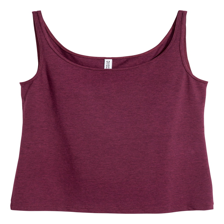

**Actual Caption**: Fitted vest top in soft jersey.
**Predicted Caption**: Fitted vest top in soft jersey.


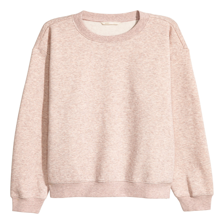

**Actual Caption**: Long-sleeved top in sweatshirt fabric with ribbing at the cuffs and hem. Soft brushed inside.
**Predicted Caption**: Top in sweatshirt fabric with gently dropped shoulders, long sleeves and ribbing around the neckline, cuffs and hem.


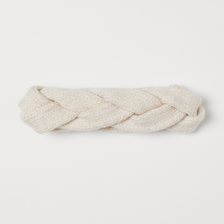

**Actual Caption**: Braided headband in a soft knit.
**Predicted Caption**: Braided headband in a soft knit.


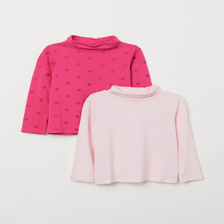

**Actual Caption**: Long-sleeved, polo-neck tops in organic cotton jersey.
**Predicted Caption**: Long-sleeved jersey tops in a soft cotton blend.


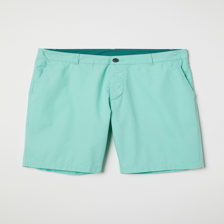

**Actual Caption**: Knee-length shorts in a cotton weave with a button fly, side pockets and a welt back pocket with a button.
**Predicted Caption**: Short shorts in a cotton weave with an elasticated drawstring waist, fake fly, side pockets and a welt back pocket with a button.


In [22]:
import os
import random
import pandas as pd
from PIL import Image
from torchvision.transforms import functional as F
import torch
from transformers import ViTImageProcessor

model = VisionEncoderDecoderModel.from_pretrained(model_output_dir)
feature_extractor = ViTImageProcessor.from_pretrained(model_output_dir)
tokenizer = AutoTokenizer.from_pretrained(model_output_dir)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

max_length = 64
num_beams = 4
gen_kwargs = {
    "max_length": max_length,
    "num_beams": num_beams,
    # "num_return_sequences": 3,
}



def load_random_image_and_caption(image_dir, captions_file):
    
    captions_df = pd.read_csv(captions_file)
    captions_df = captions_df.iloc[:5000]

    if 'image' not in captions_df.columns:
        print("Column 'image' not found in the CSV file.")
        return None, None


    random_row = captions_df.sample(n=1)
    random_image_name = random_row['image'].values[0]

    image_path = os.path.join(image_dir, random_image_name)

    if not os.path.isfile(image_path):
        print(f"Image file not found: {image_path}")
        return None, None

    if 'caption' in captions_df.columns:
        actual_caption = random_row['caption'].values[0]
    else:
        actual_caption = None

    return image_path, actual_caption

def predict_step(image_dir, captions_file):

    image_path, actual_caption = load_random_image_and_caption(image_dir, captions_file)

    if image_path is None or actual_caption is None:
        return

    i_image = Image.open(image_path)
    if i_image.mode != "RGB":
        i_image = i_image.convert(mode="RGB")
    i_image = i_image.resize((224, 224))

    display(i_image)

    image_tensor = F.to_tensor(i_image).unsqueeze(0)
    image_tensor = image_tensor.to(device)

    output_ids = model.generate(image_tensor, **gen_kwargs)

    pred = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    print(f"**Actual Caption**: {actual_caption}")
    print(f"**Predicted Caption**: {pred}")

    
image_directory = '/kaggle/input/fashionhm/images/images'
captions_csv_file = '/kaggle/input/fashionhm/output.csv'
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)
predict_step(image_directory, captions_csv_file)